In [2]:
import numpy as np
import pandas as pd
import math
import random
import re
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
essay_dset = list(pd.read_csv("/kaggle/input/essays/essays_sorted.csv").essay)

In [18]:
class CharEmbedding(nn.Module):
    def __init__(self, emb_dim=16, device="cuda", vocab_size=50000):
        super().__init__()
        self.emb_dim = emb_dim
        self.vocab_size = int(vocab_size)
        self.device = device

        self.char_embedders = nn.Embedding(self.vocab_size, self.emb_dim)

    def forward(self, words):
        """
        words: list of strings, length B
        returns:
            chars: (B, max_len, emb_dim)
            mask:  (B, max_len) float32, 1 for real chars, 0 for pad
            idxs:  (B, max_len) long, in [0, vocab_size-1]
        """
        id_seqs = []
        max_len = 0

        for w in words:
            # map unicode codepoints into [0, vocab_size-1]
            ids = [min(ord(c), self.vocab_size - 1) for c in w]
            t = torch.tensor(ids, dtype=torch.long)
            id_seqs.append(t)
            max_len = max(max_len, len(ids))

        B = len(id_seqs)
        idxs = torch.full((B, max_len), 0, dtype=torch.long)       # PAD = 0
        mask = torch.zeros(B, max_len, dtype=torch.float32)

        for i, t in enumerate(id_seqs):
            L = t.size(0)
            idxs[i, :L] = t
            mask[i, :L] = 1.0

        idxs = idxs.to(self.device)
        mask = mask.to(self.device)
        chars = self.char_embedders(idxs)  # (B, max_len, emb_dim)

        return chars, mask, idxs

    def safe_chr(self, i: int):
        # same as before
        if 0xD800 <= i <= 0xDFFF or i > 0x10FFFF:
            return "�"
        return chr(i)


In [6]:
class MultiKernelConv(nn.Module):
    def __init__(self, out_dim):
        super().__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(
                1,
                out_dim,
                (k, 16),
                padding=0,
            )
            for k in [2,3,4,5,6]
        ])

    def forward(self, x):
        B, seq, emb = x.shape     # x : (B, seq, emb)
        g = x.unsqueeze(1)        # → (B, 1, seq, 16)

        outs = []
        for conv in self.convs:
            g = F.pad(g, (0, 0, 1, 0)) # (B, 1, seq+1, 16)
            o = conv(g).flatten(-2) # (B, out_dim, seq)
            outs.append(o) # (B, out_dim, seq)


        out = torch.cat(outs, dim=1)   # (B, 5*out_dim, seq)
        return out.transpose(-2,-1) # (B, seq, 5*out_dim)

In [7]:
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # one big linear instead of 4 separate ones
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=True)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=True)

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t:     (B, input_size)     input at timestep t
        h_prev:  (B, hidden_size)    hidden state from previous timestep
        c_prev:  (B, hidden_size)    cell state from previous timestep
        """
        
        gates = self.x2h(x_t) + self.h2h(h_prev)
        
        # Each gate has shape: (B, hidden_size)
        i, f, g, o = gates.chunk(4, dim=-1)

        i = torch.sigmoid(i)      # (B, hidden_size)
        f = torch.sigmoid(f)      # (B, hidden_size)
        o = torch.sigmoid(o)      # (B, hidden_size)
        g = torch.tanh(g)         # (B, hidden_size)

        c_t = f * c_prev + i * g
        h_t = o * torch.tanh(c_t)

        return h_t, c_t # (B, hidden_size), (B, hidden_size)

In [8]:
class MyBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size = 32):
        super().__init__()
        self.fwd = MyLSTMCell(input_size, hidden_size)
        self.bwd = MyLSTMCell(input_size, hidden_size)

    def forward(self, x):
        # x: (B, seq, 5*out_dim)
        B, seq, embed_dim = x.size()
        h_f = x.new_zeros(B, self.fwd.hidden_size)
        c_f = x.new_zeros(B, self.fwd.hidden_size)

        h_b = x.new_zeros(B, self.bwd.hidden_size)
        c_b = x.new_zeros(B, self.bwd.hidden_size)

        f_out = []
        for t in range(seq):
            h_f, c_f = self.fwd(x[:, t], h_f, c_f)
            f_out.append(h_f.unsqueeze(1))

        b_out = []
        for t in reversed(range(seq)):
            h_b, c_b = self.bwd(x[:, t], h_b, c_b)
            b_out.append(h_b.unsqueeze(1))

        b_out.reverse()

        f_out = torch.cat(f_out, dim=1)   # (B, seq, H)
        b_out = torch.cat(b_out, dim=1)   # (B, seq, H)

        return torch.cat([f_out, b_out], dim=-1)  # (B, seq, 2H)


In [9]:
class SubwordModel(nn.Module):
    def __init__(self, embed_dim=16, conv_dim=16, hidden=32):
        super().__init__()
        self.conv = MultiKernelConv(conv_dim)
        self.bilstm = MyBiLSTM(conv_dim * 5, hidden)
        
        self.decode = nn.Sequential(
            nn.LayerNorm(2*hidden),
            nn.Linear(2*hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, 1),
            nn.Flatten(-2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x, mask = None):
        """
        x:     (B, seq, 16)
        """
        c = self.conv(x)         # (B, seq, 5)
        out = self.bilstm(c)     # (B, seq, 2*hidden)
        out = self.decode(out)   # (B, seq)
        return out

In [10]:
class WordLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.x2h = nn.Linear(input_size, 2*hidden_size, bias=True)
        self.h2h1 = nn.Linear(hidden_size, 2*hidden_size, bias=True)
        self.h2h2 = nn.Linear(hidden_size, 2*hidden_size, bias=True)

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t:     (B, input_size)     input at timestep t
        h_prev:  (B, hidden_size)
        c_prev:  (B, hidden_size)
        """
        
        gates = self.x2h(x_t) + self.h2h1(h_prev) + self.h2h2(c_prev)
        
        hidden, context = gates.chunk(2, dim=-1)

        return hidden, context # (B, hidden_size), (B, hidden_size)

In [11]:
class SubwordChunker(nn.Module):
    def __init__(self, emb_dim=16, hidden_size=64, max_sub = 16):
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.max_sub = max_sub

        self.cell = MyLSTMCell(input_size=emb_dim, hidden_size=hidden_size)

    def forward(self, c, sub, idxs):
        """
        c:    (B, seq, emb_dim)   char embeddings (no batch)
        sub:  (B, seq,)           subword scores in [0,1] from SubwordModel
        idxs: (B, seq,)            subword scores in [0,1] from SubwordModel
        """
        device = c.device
        B, seq, emb_dim = c.shape

        hidden_ = torch.zeros(B, self.hidden_size, device=device, dtype=c.dtype)
        context = torch.zeros(B, self.hidden_size, device=device, dtype=c.dtype)

        # we will fill these AFTER the time loop
        segment_bounds = [[] for _ in range(B)]  # list of (start, end, hidden_vec)
        tensor_idx = [0] * B

        prev_wt = sub[:, 0]

        # -------- main time loop: only compute hidden_ and record boundaries --------
        for t in range(seq):
            hidden_, context = self.cell(c[:, t, :], hidden_, context)  # (B,H),(B,H)

            wts = prev_wt / (sub[:, t] + 1e-8)

            for i in range(B):
                seg_len = t - tensor_idx[i]
                if wts[i].item() > 1 or seg_len >= self.max_sub:
                    start = tensor_idx[i]
                    end = t
                    if end > start:
                        # record segment boundary and hidden state
                        segment_bounds[i].append((start, end, hidden_[i].clone()))
                    tensor_idx[i] = t  # new segment starts here

            hidden_ = hidden_ * wts.unsqueeze(1)
            prev_wt = sub[:, t]

        # flush last open segment per batch item
        for i in range(B):
            start = tensor_idx[i]
            end = seq
            if end > start:
                segment_bounds[i].append((start, end, hidden_[i].clone()))

        # -------- after the loop: build tensors from recorded boundaries --------
        segments = []
        response = []
        true_idx = []
        masks    = []

        for i in range(B):
            bounds = segment_bounds[i]
            if len(bounds) == 0:
                segments.append(torch.empty((0, self.hidden_size),
                                            device=device, dtype=c.dtype))
                response.append(torch.empty((0, self.max_sub, self.emb_dim),
                                            device=device, dtype=c.dtype))
                true_idx.append(torch.empty((0, self.max_sub),
                                            device=device, dtype=torch.int64))
                masks.append(torch.empty((0, self.max_sub),
                                         device=device, dtype=torch.float32))
                continue

            seg_list   = []
            resp_list  = []
            idx_list   = []
            mask_list  = []

            for (start, end, h_vec) in bounds:
                seg_len = end - start
                seg_list.append(h_vec.unsqueeze(0))  # (1,H)

                block = torch.zeros((1, self.max_sub, self.emb_dim),
                                    device=device, dtype=c.dtype)
                idx_block = torch.zeros((1, self.max_sub),
                                        device=device, dtype=torch.int64)
                mask_block = torch.zeros((1, self.max_sub),
                                         device=device, dtype=torch.float32)

                use_len = min(seg_len, self.max_sub)
                block[0, :use_len, :] = c[i, start:start+use_len, :]
                idx_block[0, :use_len] = idxs[i, start:start+use_len]
                mask_block[0, use_len-1] = 1  # like your original “end-of-subword” flag

                resp_list.append(block)
                idx_list.append(idx_block)
                mask_list.append(mask_block)

            segments.append(torch.cat(seg_list, dim=0))
            response.append(torch.cat(resp_list, dim=0))
            true_idx.append(torch.cat(idx_list, dim=0))
            masks.append(torch.cat(mask_list, dim=0))

        return segments, response, masks, true_idx

In [12]:
class SubwordDecoder(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=32, char_dim=16, max_len=16):
        super().__init__()
        self.max_len = max_len
        self.decoder_rnn = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.out_proj = nn.Linear(hidden_dim, char_dim)
        self.mask_proj = nn.Sequential(nn.Linear(char_dim, char_dim), nn.GELU(), nn.Linear(char_dim, 1))

    def forward(self, z):
        # z: (X, 64)
        X = z.size(0)

        # repeat latent vector for each timestep
        z_rep = z.unsqueeze(1).repeat(1, self.max_len, 1)  # (X,16,64)

        # decode
        decoded, _ = self.decoder_rnn(z_rep)               # (X,16,hidden_dim)
        decoded = self.out_proj(decoded)                   # (X,16,4)
        mask = self.mask_proj(decoded).flatten(-2)         # (X,16)
        return decoded, mask


In [13]:
class SubwordToStr(nn.Module):
    def __init__(self, char_dim = 16, vocab_size=50000, max_len=16):
        super().__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size

        # final projection → vocab logits
        self.out_proj = nn.Linear(char_dim, vocab_size)

    def forward(self, z):
        """
        z: (B, X, 16)
        """
        logits = self.out_proj(z)                     # (X, 16, 50000)
        return logits

In [14]:
class NextSubwordLM(nn.Module):
    def __init__(self, emb_dim=64, hidden_size=128, n_heads=4, num_layers=2, max_len=512):
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.max_len = max_len

        # optional input projection if you want a different internal dim
        self.in_proj = nn.Linear(emb_dim, hidden_size) if hidden_size != emb_dim else nn.Identity()

        # learned positional embedding
        self.pos_emb = nn.Embedding(max_len, hidden_size)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=n_heads,
            dim_feedforward=hidden_size * 4,
            batch_first=True,          # use (B, T, D)
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # project back to embedding space for “next subword” prediction
        self.out = nn.Linear(hidden_size, emb_dim)

    def forward(self, sw_embs: torch.Tensor):
        """
        sw_embs: (N, emb_dim) or (B, N, emb_dim)
        Returns:
            pred: (1, emb_dim) if input was (N, emb_dim)
                  (B, emb_dim) if input was (B, N, emb_dim)
        """
        if sw_embs.dim() == 2:
            # (N, D) -> (1, N, D)
            sw_embs = sw_embs.unsqueeze(0)
            single = True
        else:
            single = False

        B, T, D = sw_embs.shape
        device = sw_embs.device

        # project to model dimension
        x = self.in_proj(sw_embs)              # (B, T, hidden_size)

        # add positional embeddings
        pos_ids = torch.arange(T, device=device).unsqueeze(0)  # (1, T)
        pos = self.pos_emb(pos_ids)                            # (1, T, hidden_size)
        x = x + pos                                            # (B, T, hidden_size)

        # transformer encoder
        x = self.encoder(x)                                    # (B, T, hidden_size)

        # use last token representation as context
        last = x[:, -1, :]                                     # (B, hidden_size)

        # predict next subword embedding
        pred = self.out(last)                                  # (B, emb_dim)

        if single:
            return pred.squeeze(0)                             # (emb_dim,)
        return pred                                            # (B, emb_dim)


In [19]:
char_embedder = CharEmbedding(16, DEVICE).to(DEVICE)
subword_model = SubwordModel().to(DEVICE)
subword_chunk = SubwordChunker().to(DEVICE)
subword_decode = SubwordDecoder().to(DEVICE)
subword_str = SubwordToStr().to(DEVICE)
next_subword = NextSubwordLM().to(DEVICE)

In [20]:
CE_criterion = nn.CrossEntropyLoss()
MSE_criterion = nn.MSELoss()

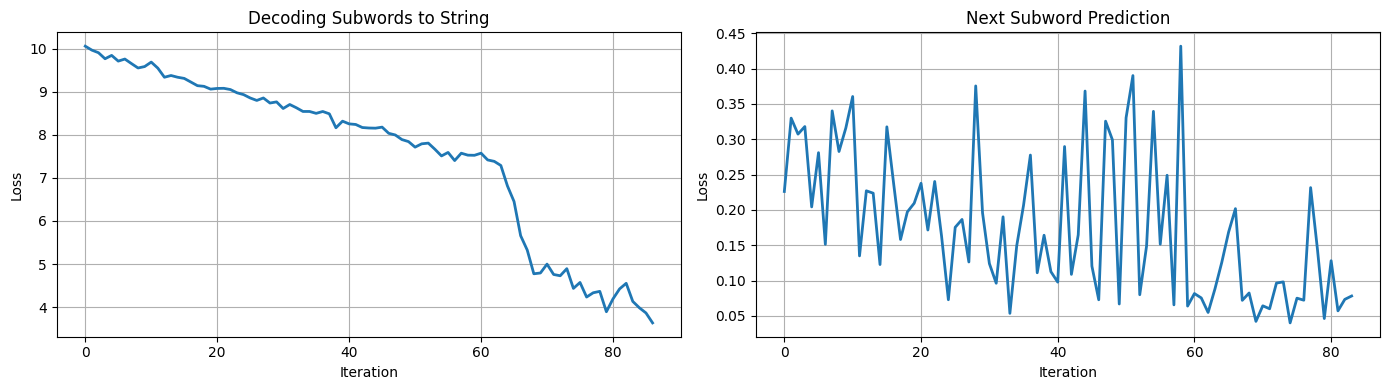

KeyboardInterrupt: 

In [32]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

# assume these already exist:
# char_embedder, subword_model, subword_chunk
# subword_decode, subword_str, next_subword
# CE_criterion (with ignore_index), MSE_criterion, DEVICE

PAD_ID = 0  # used for invalid chars / padding
vocab_size_expected = int(5e4)  # if you used this in subword_str

optimizer2 = torch.optim.Adam(
    list(subword_decode.parameters()) +
    list(subword_str.parameters()),
    lr=1e-4
)

optimizer1 = torch.optim.Adam(
    list(next_subword.parameters()),
    lr=3e-4
)

essay_dset = list(essay_dset)

char_embedder.train()
subword_model.train()
subword_chunk.train()
subword_decode.train()
subword_str.train()
next_subword.train()

for step, essay in enumerate(essay_dset):
    # -------------------------------------------------------
    # 0) Split essay into context (essay1) and continuation (essay2)
    # -------------------------------------------------------
    tokens = essay.split()
    if len(tokens) <= 5:
        continue

    essay1 = " ".join(tokens[:5])
    essay2 = " ".join(tokens[5:])

    # =======================================================
    # 1) SUBWORD → STRING DECODER TRAINING (optimizer2)
    # =======================================================
    with torch.no_grad():
        chars, mask, idxs = char_embedder([essay1])   # (1, seq, emb)
        chars = chars.to(DEVICE)
        idxs  = idxs.to(DEVICE)

        subs = subword_model(chars)                   # (1, seq)
        subwords, labels, masks, ords = subword_chunk(chars, subs, idxs)

        subwords = subwords[:5]
        labels   = labels[:5]
        masks    = masks[:5]
        ords     = ords[:5]

    loss_decode = 0.0

    # now track grad only for decoder
    for sw, lbl, msk, ord_msk in zip(subwords, labels, masks, ords):
        decoded, eos = subword_decode(sw)        # your shape

        # reconstruction loss in embedding space
        mse = 2 * MSE_criterion(decoded, lbl)

        # EOS / boundary loss (leave as-is; you know its shapes)
        ce_eos = CE_criterion(msk, eos)

        # character-level CE
        pred_str = subword_str(decoded)          # (num_seg, max_sub, vocab_size)
        vocab_size = pred_str.size(-1)

        # defensive: make sure vocab size matches what you expect
        if vocab_size != vocab_size_expected:
            # optional sanity check
            pass

        logits = pred_str.reshape(-1, vocab_size)      # (N*max_sub, vocab)

        # flatten ord_msk and clamp to [0, vocab_size-1]
        targets = ord_msk.reshape(-1).long()
        # mark invalid ids (>= vocab_size) as PAD_ID so CE ignores them
        invalid = (targets < 0) | (targets >= vocab_size)
        targets[invalid] = PAD_ID

        ce_chars = CE_criterion(logits, targets)

        loss_decode += mse + ce_eos + ce_chars

    loss_decode = loss_decode / max(1, len(subwords))

    optimizer2.zero_grad()
    loss_decode.backward()
    optimizer2.step()

    losses1.append(loss_decode.item())

    # =======================================================
    # 2) NEXT-SUBWORD LM TRAINING (optimizer1)
    # =======================================================

    if len(essay2.strip()) == 0:
        continue

    with torch.no_grad():
        # context subwords (essay1)
        chars1, mask1, idxs1 = char_embedder([essay1])
        chars1 = chars1.to(DEVICE)
        idxs1  = idxs1.to(DEVICE)

        subs1 = subword_model(chars1)
        subwords1, labels1, masks1, ords1 = subword_chunk(chars1, subs1, idxs1)
        if len(subwords1) == 0:
            continue
        sw_seq1 = subwords1[0]                     # (N1, emb_dim)

        # target subwords (essay2)
        chars2, mask2, idxs2 = char_embedder([essay2])
        chars2 = chars2.to(DEVICE)
        idxs2  = idxs2.to(DEVICE)

        subs2 = subword_model(chars2)
        subwords2, labels2, masks2, ords2 = subword_chunk(chars2, subs2, idxs2)
        if len(subwords2) == 0:
            continue
        sw_seq2 = subwords2[0]                     # (N2, emb_dim)

    if sw_seq1.size(0) < 1 or sw_seq2.size(0) < 1:
        continue

    # one-step LM: predict FIRST subword of essay2
    pred_next = next_subword(sw_seq1)              # (emb_dim,) or (1, emb_dim)

    if pred_next.dim() == 1:
        pred_vec = pred_next
    else:
        pred_vec = pred_next.squeeze(0)

    target_vec = sw_seq2[0]

    loss_next = MSE_criterion(pred_vec, target_vec)

    optimizer1.zero_grad()
    loss_next.backward()
    optimizer1.step()

    losses2.append(loss_next.item())

    # =======================================================
    # 3) PLOTTING (throttled)
    # =======================================================
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    axs[0].plot(losses1, linewidth=2)
    axs[0].set_title("Decoding Subwords to String")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)

    axs[1].plot(losses2, linewidth=2)
    axs[1].set_title("Next Subword Prediction")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Loss")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


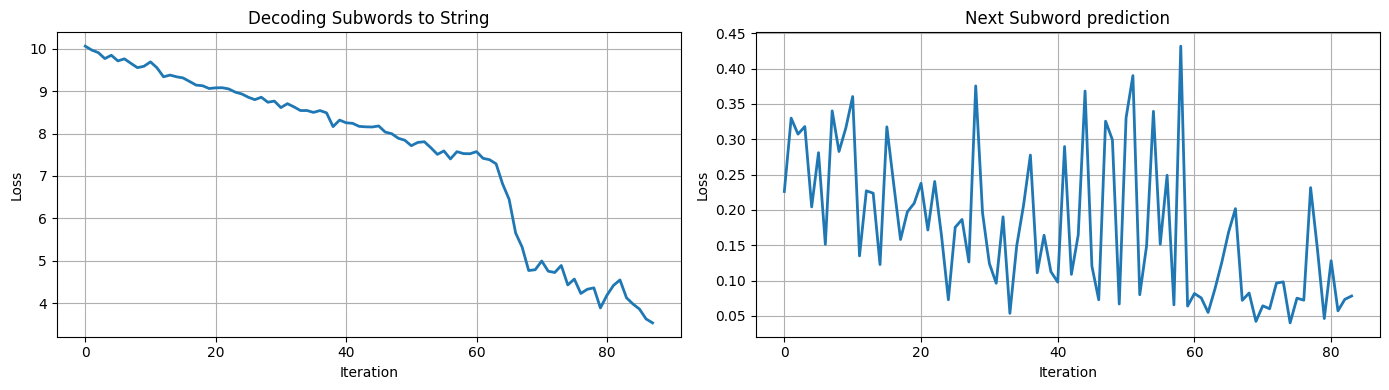

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].plot(losses1, linewidth=2)
axs[0].set_title("Decoding Subwords to String")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

axs[1].plot(losses2, linewidth=2)
axs[1].set_title("Next Subword prediction")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Loss")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [33]:
def safe_chr(i):
    if 0xD800 <= i <= 0xDFFF or i > 0x10FFFF: 
        return "�" 
    return chr(i)

In [37]:
# make sure models are in eval mode
char_embedder.eval()
subword_model.eval()
subword_chunk.eval()
subword_decode.eval()
subword_str.eval()
next_subword.eval()

@torch.no_grad()
def generate_next_subwords_for_last_essay(
    num_subwords=5,
    device=DEVICE,
):
    context = "I wish I were a "

    # 2. Get char embeddings + subword segmentation for context
    chars, mask, idxs = char_embedder([context])   # (1, seq, emb_dim), (1, seq), (1, seq)
    chars = chars.to(device)
    idxs  = idxs.to(device)

    subs = subword_model(chars)                    # (1, seq)
    subwords, labels, masks, ords = subword_chunk(chars, subs, idxs)
    # subwords is a list of length B=1, each is (num_segments, emb_dim)
    sw_seq = subwords[0]                           # (N, emb_dim)

    # 3. Autoregressively predict next subword embeddings
    generated_embs = []
    ctx = sw_seq.clone()

    for _ in range(num_subwords):
        # NextSubwordLM / Transformer: (N, emb_dim) -> (emb_dim,) or (1, emb_dim)
        pred_emb = next_subword(ctx)               # shape depends on your implementation

        if pred_emb.dim() == 1:
            emb = pred_emb.unsqueeze(0)            # (1, emb_dim)
        else:
            emb = pred_emb                         # already (1, emb_dim) or similar

        generated_embs.append(emb.squeeze(0))
        # append to context for next prediction
        ctx = torch.cat([ctx, emb], dim=0)

    # 4. Decode each predicted subword embedding into characters
    generated_strings = []

    for emb in generated_embs:
        emb_in = emb.unsqueeze(0).to(device)       # (1, emb_dim)

        # subword_decode was trained on a sequence of subword embeddings,
        # but it should handle (1, emb_dim) the same way as a 1-length sequence.
        decoded, eos = subword_decode(emb_in)      # expected: (1, max_sub, something), (1, max_sub)

        # Turn decoded char representation into vocab logits
        # pred_str: (1, max_sub, vocab_size)
        pred_str = subword_str(decoded)

        # Greedy decode over vocab
        char_ids = pred_str.argmax(dim=-1)[0]      # (max_sub,)

        # EOS position from eos mask, if it exists / is meaningful
        if eos is not None and eos[0].any():
            eos_pos = eos[0].argmax().item()
            char_ids = char_ids[:eos_pos+1]

        # Map ids to actual unicode chars
        chars_out = ''.join(safe_chr(int(i)) for i in char_ids)
        generated_strings.append(chars_out)

    # 5. Stitch them together as "next text"
    generated_text = ''.join(generated_strings)

    return context, generated_strings, generated_text

# ---- run inference ----
context, gen_subwords, gen_text = generate_next_subwords_for_last_essay(num_subwords=5)

print("=== Context ===")
print(context)
print("\n=== Generated subwords ===")
for s in gen_subwords:
    print(repr(s))
print("\n=== Generated continuation ===")
print(gen_text)


=== Context ===
I wish I were a 

=== Generated subwords ===
'fn'
'ɱ'
'e'
'벱'
' '

=== Generated continuation ===
fnɱe벱 
